In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [17]:
def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
    
def train_mse(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = LSTM(input_dim, hidden_dim,  n_layers,output_dim)
    
    # Defining loss function and optimizer
    criterion1 = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    mseloss_train = []
    mseloss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h,c = model.init_hidden(batch_size)
        avg_loss1 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            #c = c.data
            model.zero_grad()
            
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float())
            loss1.backward()
           
            optimizer.step()
            avg_loss1 += loss1.item()
        
        avg_loss1 /= length
        mseloss_train.append(avg_loss1)
        print("Epoch {}/{} Done, Total Training MSELoss: {}".format(epoch, EPOCHS, avg_loss1))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        
        loss1 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss1 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion1(out, label.float()).item()
            avg_loss1 += testloss
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        mseloss_test.append(avg_loss1)    
        print("Total Testing MSELoss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, mseloss_train, mseloss_test, predictions, values

def train_l1(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    l1loss_train = []
    l1loss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h = model.init_hidden(batch_size)
        avg_loss2 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            model.zero_grad()

            out = model.forward(x.float())
            
            loss2 = criterion2(out, label.float())
            loss2.backward()
            optimizer.step()
            avg_loss2 += loss2.item()
        
        avg_loss2 /= length
        l1loss_train.append(avg_loss2)
        print("Epoch {}/{} Done, Total Training L1Loss: {}".format(epoch, EPOCHS, avg_loss2))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion2 = nn.L1Loss()
        
        loss2 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion2(out, label.float()).item()
            avg_loss2 += testloss
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
        
        l1loss_test.append(avg_loss2)
        print("Total Testing L1Loss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, l1loss_train, l1loss_test, predictions, values

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        
        loss1 = 0
        loss2 = 0
        for x, label in test_loader:
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float()).item()
            loss2 = criterion2(out, label.float()).item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        print("Total MSELoss: {}".format(loss1))
        print("Total L1Loss: {}".format(loss2))
        
            
    return predictions, values, loss1,loss2

In [18]:
def plot(predictions, values, dataset_name):
    plt.figure(figsize=(14,10))
    plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
    plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
    plt.title('Predicted and actual values on {}'.format(dataset_name))
    plt.ylabel(dataset_name)
    plt.xlabel('Time Points')
    plt.legend()

def plot_loss(loss_train, loss_test, dataset_name, isL1):
    loss_name = "L1" if isL1 else "MSE"
    plt.figure(figsize=(6, 4))
    plt.plot(loss_train, color="g", label="Training")
    plt.plot(loss_test, color="b", label="Testing")
    plt.title('Plot of train and test {} loss vs iterations for {}'.format(loss_name, dataset_name))
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss' if isL1 else 'MSE Loss')
    plt.legend()

def run(dataset_df, column_i, dataset_name, date_column):
    dataset_df[date_column] = pd.to_datetime(dataset_df[date_column])
    dataset_df.set_index(date_column,inplace=True)
    dataset_df = pd.DataFrame(dataset_df[dataset_df.columns[column_i-1]])
    dataset_df.dropna(inplace=True)

    # Scaling the input data
    sc = MinMaxScaler()
    #label_sc = MinMaxScaler()
    scaled_data = sc.fit_transform(dataset_df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    #label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))
    lookback = 5
    train_x,train_y,test_x,test_y = split_data(scaled_data, lookback)

    # Print data shape
    print('X_train.shape: ', train_x.shape)
    print('y_train.shape: ', train_y.shape)
    print('X_test.shape: ', test_x.shape) 
    print('y_test.shape: ', test_y.shape)

    batch_size = 32
    train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
    test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

    lr = 0.001
    gru_model5, mseloss_train, mseloss_test, predictions, values = train_mse(train_loader, test_loader,lr,EPOCHS=50, model_type="LSTM")
    gru_model5, l1loss_train, l1loss_test, predictions, values = train_l1(train_loader, test_loader,lr,EPOCHS=50, model_type="LSTM")

    plot(predictions, values, dataset_name)
    plot_loss(mseloss_train, mseloss_test, dataset_name, False)
    plot_loss(l1loss_train, l1loss_test, dataset_name, True)

In [19]:
dataset_folder = "../../dataset/"
artificial_data1 = pd.read_csv(dataset_folder + "Artificial_trend.csv")
artificial_data2 = pd.read_csv(dataset_folder + "Artificial_trend1.csv")
msft_data = pd.read_csv(dataset_folder + "microsoft.csv")
oil_data = pd.read_csv(dataset_folder + "oil.csv")
sp500_data = pd.read_csv(dataset_folder + "sp500.csv")
bitcoin_data = pd.read_csv(dataset_folder + "coin.csv")

## Artificial Data 1

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.047131132505575685
Total Testing MSELoss: 0.016021810472011566
Total Time Elapsed: 1.3980117000000973 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.014639152691745618
Total Testing MSELoss: 0.003024905687198043
Total Time Elapsed: 1.3600710000000618 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.006085374316211488
Total Testing MSELoss: 0.00021023594308644533
Total Time Elapsed: 1.318387199999961 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0010820959284031702
Total Testing MSELoss: 0.00021681157522834837
Total Time Elapsed: 1.320056100000329 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0006352318666288808
Total Testing MSELoss: 3.9076210669009015e-05
Total Time Elapsed: 1.3200786999996126 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0007660072846552434
Total Testing MSELoss

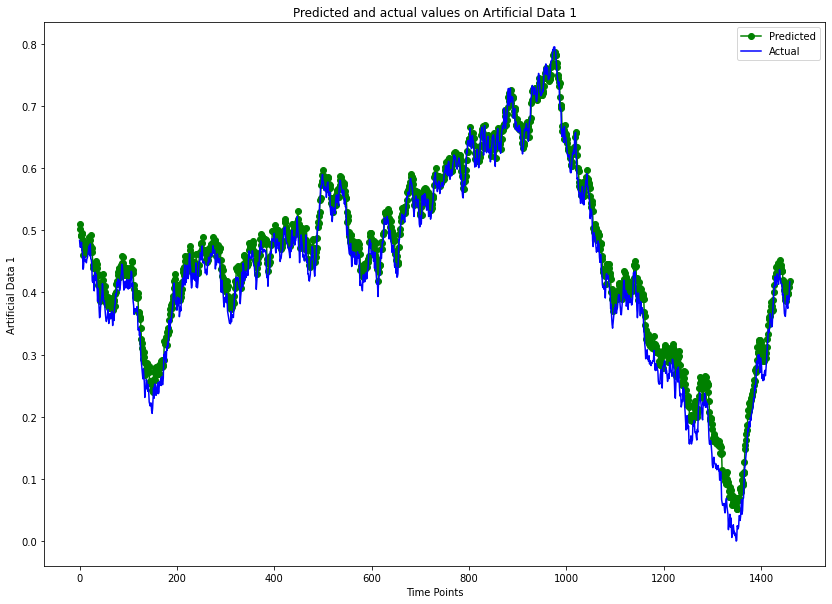

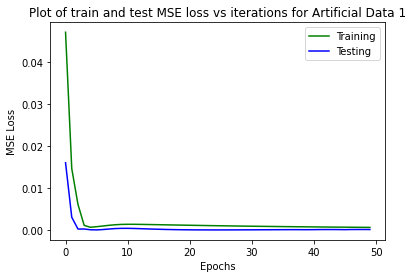

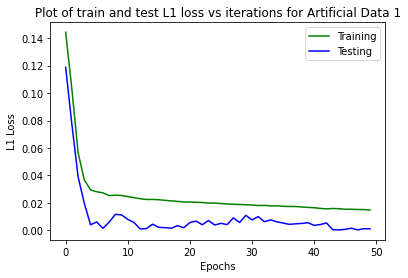

In [20]:
run(artificial_data1, 1, "Artificial Data 1", "date")

## Artificial Data 2

X_train.shape:  (5842, 5, 1)
y_train.shape:  (5842, 1)
X_test.shape:  (1460, 5, 1)
y_test.shape:  (1460, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.04789560030525995
Total Testing MSELoss: 0.15237101912498474
Total Time Elapsed: 1.244357100000343 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.019373766514475862
Total Testing MSELoss: 0.07770149409770966
Total Time Elapsed: 1.2448540000004868 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.009612698551391477
Total Testing MSELoss: 0.004898054990917444
Total Time Elapsed: 1.2771228000001429 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0023795507271303336
Total Testing MSELoss: 0.00045127415796741843
Total Time Elapsed: 1.2681041999994704 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0012602240148136023
Total Testing MSELoss: 0.0008366901893168688
Total Time Elapsed: 1.3199799000003622 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0017365157169419096
Total Testing MSELoss: 0.0

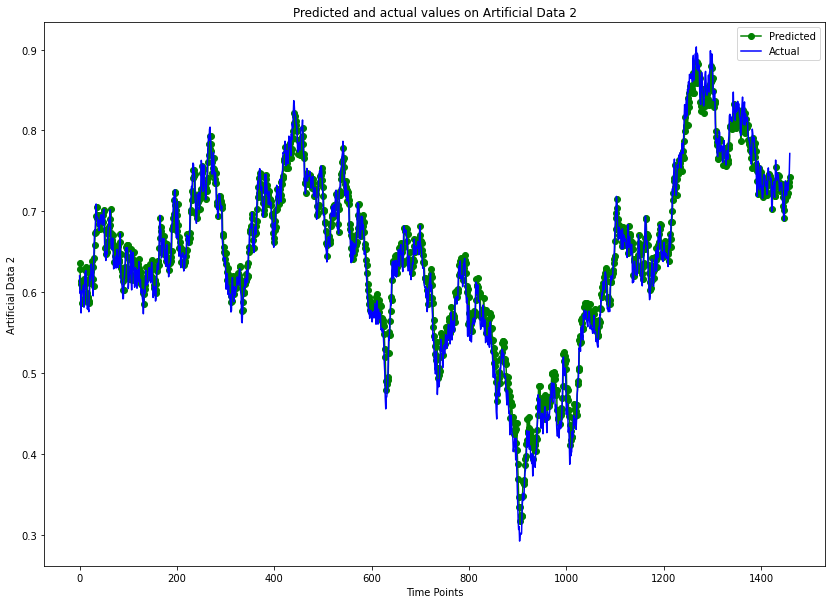

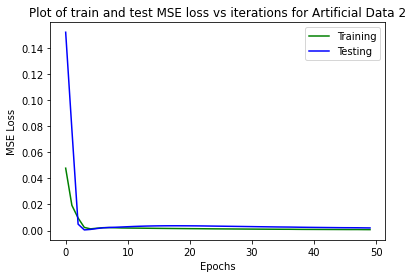

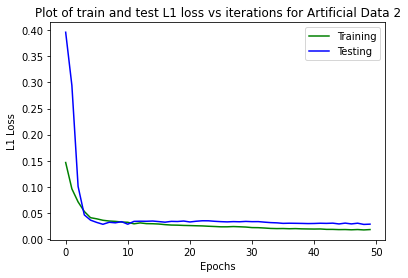

In [21]:
run(artificial_data2, 1, "Artificial Data 2", "date")

## Microsoft

X_train.shape:  (1205, 5, 1)
y_train.shape:  (1205, 1)
X_test.shape:  (301, 5, 1)
y_test.shape:  (301, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.001293389880568095
Total Testing MSELoss: 0.14149968326091766
Total Time Elapsed: 0.2679425000005722 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.04759489865967692
Total Testing MSELoss: 0.4233006238937378
Total Time Elapsed: 0.26450220000060654 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.016087811581225676
Total Testing MSELoss: 0.23824721574783325
Total Time Elapsed: 0.2653189000002385 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0185257768440548
Total Testing MSELoss: 0.15615172684192657
Total Time Elapsed: 0.26509749999968335 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.011918621862089305
Total Testing MSELoss: 0.01632860116660595
Total Time Elapsed: 0.2795835000006264 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.00663708155804449
Total Testing MSELoss: 0.0212033241987

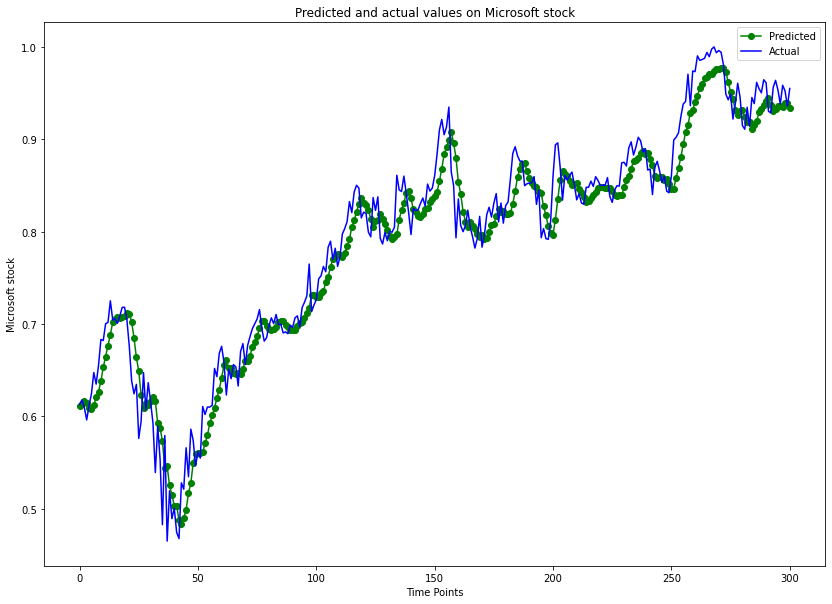

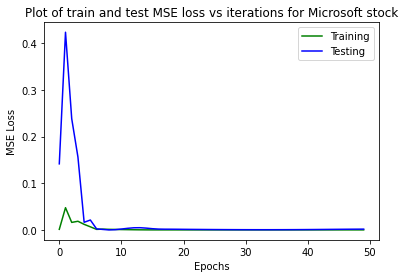

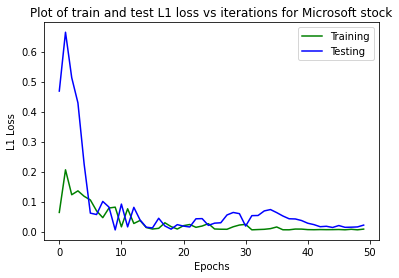

In [22]:
run(msft_data, 4, "Microsoft stock", "Date")

## Crude oil prices

X_train.shape:  (1219, 5, 1)
y_train.shape:  (1219, 1)
X_test.shape:  (305, 5, 1)
y_test.shape:  (305, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.125563448798953
Total Testing MSELoss: 0.04221702367067337
Total Time Elapsed: 0.31823310000072524 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.055223111577920224
Total Testing MSELoss: 0.021753165870904922
Total Time Elapsed: 0.2855095999993864 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.04038970283918867
Total Testing MSELoss: 0.02039157785475254
Total Time Elapsed: 0.28587729999981093 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0356027313943119
Total Testing MSELoss: 0.015297552570700645
Total Time Elapsed: 0.2965870999996696 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.03175435439181073
Total Testing MSELoss: 0.011560534127056599
Total Time Elapsed: 0.2848274999996647 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.027976448724266925
Total Testing MSELoss: 0.008756916970

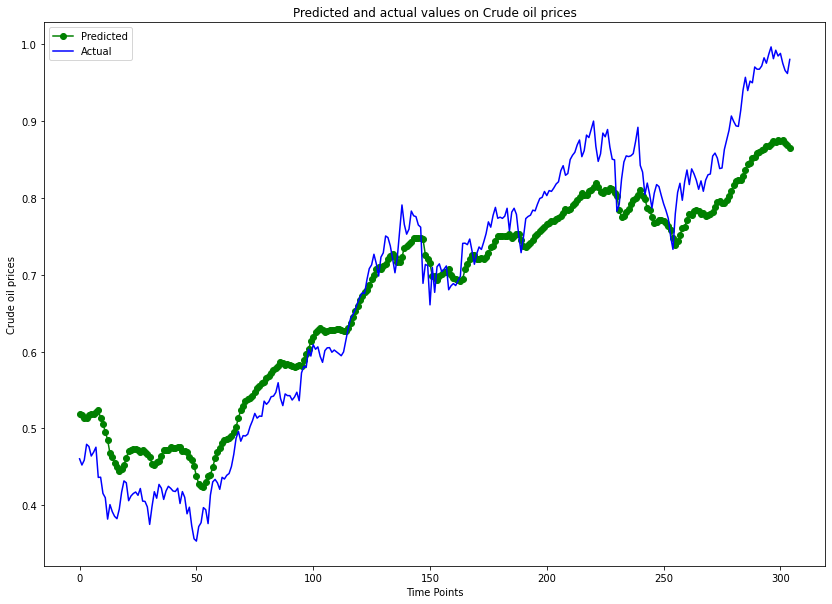

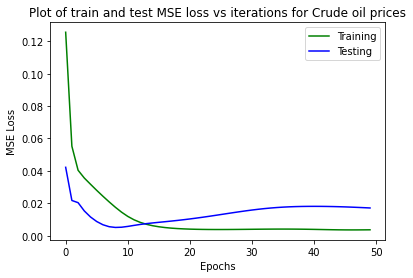

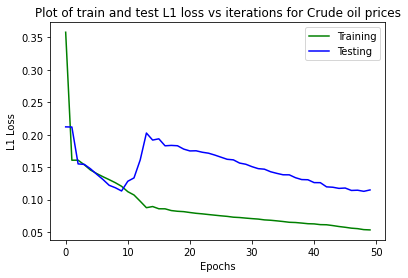

In [23]:
oil_data = oil_data[oil_data.DCOILBRENTEU != "."]
run(oil_data, 1, "Crude oil prices", "DATE")

## S&P 500

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0033824270895737836
Total Testing MSELoss: 0.7159823775291443
Total Time Elapsed: 0.3252303999997821 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.00039364844933167183
Total Testing MSELoss: 0.622641384601593
Total Time Elapsed: 0.31924939999953494 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.0005096234997488125
Total Testing MSELoss: 0.5879481434822083
Total Time Elapsed: 0.30511370000022 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.00047974044000459963
Total Testing MSELoss: 0.56417316198349
Total Time Elapsed: 0.36073899999973946 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0004599476675967263
Total Testing MSELoss: 0.5426139831542969
Total Time Elapsed: 0.3226615000003221 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.00044936849555845333
Total Testing MSELoss: 0.522777855

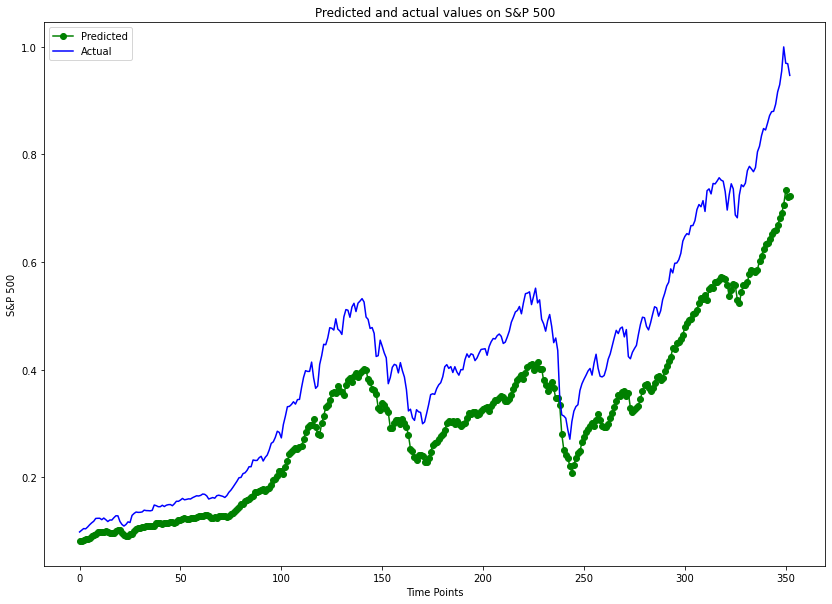

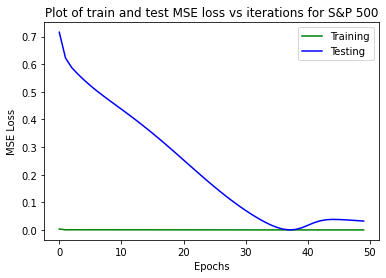

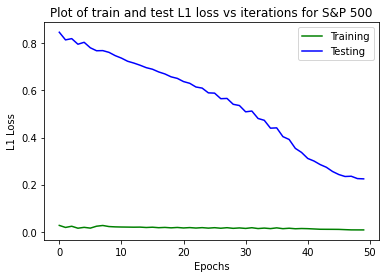

In [24]:
run(sp500_data, 1, "S&P 500", "Date")

## Bitcoin

X_train.shape:  (2389, 5, 1)
y_train.shape:  (2389, 1)
X_test.shape:  (597, 5, 1)
y_test.shape:  (597, 1)
Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.0019330230887158687
Total Testing MSELoss: 0.16168630123138428
Total Time Elapsed: 0.5708758000000671 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.002735478046102803
Total Testing MSELoss: 0.1527058184146881
Total Time Elapsed: 0.5634300000001531 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.003878719809226884
Total Testing MSELoss: 0.16293944418430328
Total Time Elapsed: 0.5511850000002596 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0037441875329245642
Total Testing MSELoss: 0.1597566455602646
Total Time Elapsed: 0.5256003000004057 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.003989606694287088
Total Testing MSELoss: 0.16396810114383698
Total Time Elapsed: 0.5321278000001257 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.003761927691849609
Total Testing MSELoss: 0.1566308587

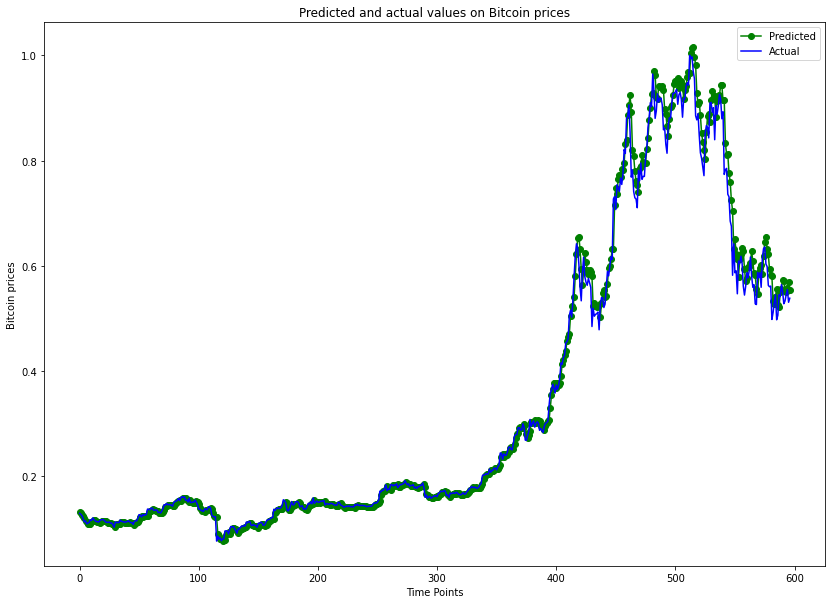

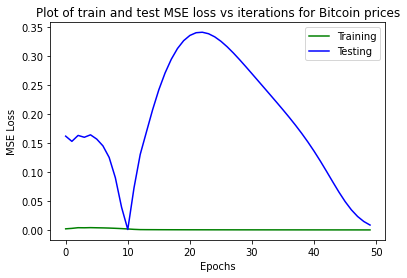

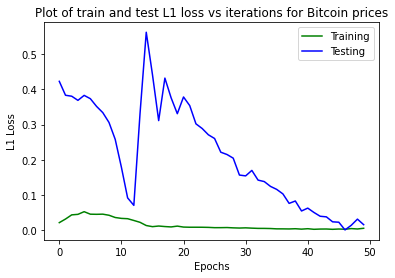

In [26]:
run(bitcoin_data, 7, "Bitcoin prices", "Date")